In [24]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from modules.rq_vae import RQ_VAE
from tqdm import tqdm
import pandas as pd
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from einops import rearrange

In [ ]:
embeddings = np.load('./data/ml-25m-vit_bert/embed_text.npy')

emb_shape = np.array(embeddings).shape
vae_input_dim = emb_shape[1]
vae_hidden_dims=[768, 512, 256]
vae_embed_dim=128

vae_codebook_size=256
dropout=0.1
vae_codebook_normalize=True
vae_sim_vq=False
vae_n_layers=3

use_kmeans_init=True

learning_rate=0.001
weight_decay=0.1

batch_size=2048
commitment_weight=0.25
iterations=800

embeddings = torch.tensor(embeddings, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(embeddings), batch_size=batch_size, shuffle=True)

model = RQ_VAE(
    input_dim=vae_input_dim,
    latent_dim=vae_embed_dim,
    hidden_dims=vae_hidden_dims,
    codebook_size=vae_codebook_size,
    codebook_kmeans=use_kmeans_init,
    codebook_normalization=vae_codebook_normalize,
    codebook_sim_vq=vae_sim_vq,
    num_layers=vae_n_layers,
    beta_commit=commitment_weight,
    num_cat_features=0,
)

scaler = GradScaler(device='cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [34]:
def train_with_codebook_tracking(model, train_loader, optimizer, device, num_epochs=250):
    """Train the model while tracking codebook changes"""
    scaler = GradScaler(device=device)
    epoch_progress = tqdm(range(num_epochs), desc="Training Progress")
    
    # For tracking codebook changes
    codebook_snapshots = []
    # Track more frequently early in training when changes are more rapid
    snapshot_epochs = set([0, 10, 20, 50, 100, 250, 500, 1000, num_epochs-1]) 
    
    # Take initial snapshot before training
    codebook_tensors = []
    for layer in model.residual_quantize_stack:
        codebook = layer.embedding.weight.clone().detach().cpu()
        codebook_tensors.append(codebook)
    
    codebook_snapshots.append({
        'epoch': 0,
        'codebooks': codebook_tensors,
        'metrics': {'loss': 0, 'recon_loss': 0, 'rqvae_loss': 0, 'p_unique_ids': 0}
    })
    
    for epoch in epoch_progress:
        model.train()
        
        total_loss = 0
        total_reconstruction_loss = 0
        total_rqvae_loss = 0
        total_p_unique_ids = 0
        
        (embeddings_batch,) = next(iter(train_loader))
        # Zero the gradients
        optimizer.zero_grad()
        embeddings_batch = embeddings_batch.to(device)
        
        # Forward pass
        with autocast('cuda' if torch.cuda.is_available() else 'cpu'):
            loss, recon_loss, rqvae_loss, _, p_unique_ids = model(embeddings_batch)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        total_reconstruction_loss += recon_loss.item()
        total_rqvae_loss += rqvae_loss.item()
        total_p_unique_ids += p_unique_ids.item()
        
        # Calculate average metrics
        avg_loss = total_loss / len(train_loader)
        avg_recon_loss = total_reconstruction_loss / len(train_loader)
        avg_rqvae_loss = total_rqvae_loss / len(train_loader)
        avg_p_unique_ids = total_p_unique_ids / len(train_loader)
        
        # Save codebook snapshots at specified epochs
        if epoch in snapshot_epochs or epoch == num_epochs - 1:
            codebook_tensors = []
            for layer in model.residual_quantize_stack:
                codebook = layer.embedding.weight.clone().detach().cpu()
                codebook_tensors.append(codebook)
            
            codebook_snapshots.append({
                'epoch': epoch + 1,  # +1 because we start from 0
                'codebooks': codebook_tensors,
                'metrics': {
                    'loss': avg_loss,
                    'recon_loss': avg_recon_loss,
                    'rqvae_loss': avg_rqvae_loss,
                    'p_unique_ids': avg_p_unique_ids
                }
            })
            
        epoch_progress.set_postfix({
            "Loss": f"{avg_loss:.4f}",
            "Reconstruction": f"{avg_recon_loss:.4f}",
            "RQ-VAE": f"{avg_rqvae_loss:.4f}",
            "Unique IDs": f"{avg_p_unique_ids:.2%}"
        })
    
    return codebook_snapshots

def plot_training_metrics(codebook_snapshots):
    """Plot the evolution of training metrics over epochs"""
    epochs = [s['epoch'] for s in codebook_snapshots]
    loss = [s['metrics']['loss'] for s in codebook_snapshots]
    recon_loss = [s['metrics']['recon_loss'] for s in codebook_snapshots]
    rqvae_loss = [s['metrics']['rqvae_loss'] for s in codebook_snapshots]
    p_unique_ids = [s['metrics']['p_unique_ids'] for s in codebook_snapshots]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(epochs, loss, 'o-', label='Total Loss')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Reconstruction Loss
    axes[0, 1].plot(epochs, recon_loss, 'o-', color='orange', label='Reconstruction Loss')
    axes[0, 1].set_title('Reconstruction Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True, alpha=0.3)
    
    # RQ-VAE Loss
    axes[1, 0].plot(epochs, rqvae_loss, 'o-', color='green', label='RQ-VAE Loss')
    axes[1, 0].set_title('RQ-VAE Loss (Commitment Loss)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Unique IDs Percentage
    axes[1, 1].plot(epochs, p_unique_ids, 'o-', color='purple', label='Unique IDs')
    axes[1, 1].set_title('Percentage of Unique IDs')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Percentage')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Apply log scale for x-axis if there are many epochs
    if max(epochs) > 20:
        for ax in axes.flatten():
            ax.set_xscale('symlog', linthresh=10)
    
    plt.tight_layout()
    plt.show()

def visualize_codebook_norms(codebook_snapshots):
    """Plot how the norms of codebook vectors change during training"""
    plt.figure(figsize=(12, 8))
    
    for layer_idx in range(len(codebook_snapshots[0]['codebooks'])):
        epochs = []
        avg_norms = []
        
        for snapshot in codebook_snapshots:
            codebook = snapshot['codebooks'][layer_idx]
            norms = torch.norm(codebook, dim=1)
            epochs.append(snapshot['epoch'])
            avg_norms.append(norms.mean().item())
        
        plt.plot(epochs, avg_norms, 'o-', label=f'Layer {layer_idx+1}')
    
    plt.xlabel('Epoch')
    plt.ylabel('Average Vector Norm')
    plt.title('Evolution of Codebook Vector Norms During Training')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Apply log scale for x-axis if there are many epochs
    if max(epochs) > 20:
        plt.xscale('symlog', linthresh=10)  # Log scale but linear near zero
    
    plt.tight_layout()
    plt.show()

def visualize_codebook_distances(codebook_snapshots):
    """Plot how the pairwise distances between codebook vectors change"""
    plt.figure(figsize=(12, 8))
    
    for layer_idx in range(len(codebook_snapshots[0]['codebooks'])):
        epochs = []
        avg_distances = []
        min_distances = []
        
        for snapshot in codebook_snapshots:
            codebook = snapshot['codebooks'][layer_idx]
            # Calculate pairwise distances
            distances = torch.cdist(codebook, codebook)
            # Remove self-distances (zeros on diagonal)
            mask = ~torch.eye(distances.shape[0], dtype=bool)
            distances = distances[mask]
            
            epochs.append(snapshot['epoch'])
            avg_distances.append(distances.mean().item())
            min_distances.append(distances.min().item())
        
        plt.plot(epochs, avg_distances, 'o-', label=f'Layer {layer_idx+1} Avg Distance')
        plt.plot(epochs, min_distances, 's--', label=f'Layer {layer_idx+1} Min Distance')
    
    plt.xlabel('Epoch')
    plt.ylabel('Distance')
    plt.title('Evolution of Codebook Vector Distances During Training')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Apply log scale for x-axis if there are many epochs
    if max(epochs) > 20:
        plt.xscale('symlog', linthresh=10)
    
    plt.tight_layout()
    plt.show()

def visualize_codebook_usage(model, dataloader, device, num_samples=1000):
    """Visualize how frequently each codebook vector is used"""
    model.eval()
    # Initialize usage counts for each layer
    usage_counts = [torch.zeros(layer.embedding.weight.shape[0]) 
                    for layer in model.residual_quantize_stack]
    
    with torch.no_grad():
        sample_count = 0
        for _, (embeddings_batch,) in enumerate(dataloader):
            if sample_count >= num_samples:
                break
                
            embeddings_batch = embeddings_batch.to(device)
            
            # Get semantic IDs for each layer
            _, _, sem_ids, _ = model.get_semantic_ids(embeddings_batch)
            sem_ids = rearrange(sem_ids, "b d -> d b")  # Reshape based on your implementation
            
            # Update usage counts for each layer
            for layer_idx, ids in enumerate(sem_ids):
                for idx in ids.flatten().cpu():
                    usage_counts[layer_idx][idx] += 1
                    
            sample_count += embeddings_batch.shape[0]
            if sample_count >= num_samples:
                break
    
    # Plot usage histograms
    fig, axes = plt.subplots(len(usage_counts), 1, figsize=(15, 5*len(usage_counts)))
    if len(usage_counts) == 1:
        axes = [axes]
        
    for i, (counts, ax) in enumerate(zip(usage_counts, axes)):
        counts_np = counts.numpy()
        
        # Sort by usage count for better visualization
        sorted_indices = np.argsort(counts_np)[::-1]  # Sort in descending order
        sorted_counts = counts_np[sorted_indices]
        
        # Plot
        ax.bar(range(len(sorted_counts)), sorted_counts)
        ax.set_title(f'Layer {i+1} Codebook Usage (Sorted)')
        ax.set_xlabel('Codebook Index (Sorted by Usage)')
        ax.set_ylabel('Usage Count')
        
        # Display percentage of unused vectors
        unused = (counts_np == 0).sum()
        unused_percent = 100 * unused / len(counts_np)
        ax.text(0.95, 0.95, f'Unused: {unused}/{len(counts_np)} ({unused_percent:.1f}%)',
                transform=ax.transAxes, ha='right', va='top', 
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Plot usage distribution (another view)
    fig, axes = plt.subplots(len(usage_counts), 1, figsize=(15, 5*len(usage_counts)))
    if len(usage_counts) == 1:
        axes = [axes]
        
    for i, (counts, ax) in enumerate(zip(usage_counts, axes)):
        counts_np = counts.numpy()
        
        # Create histogram of usage counts to see distribution
        sns.histplot(counts_np[counts_np > 0], bins=30, ax=ax, kde=True)
        ax.set_title(f'Layer {i+1} Codebook Usage Distribution')
        ax.set_xlabel('Usage Count')
        ax.set_ylabel('Number of Codebook Vectors')
        
        # Display metrics
        total_vectors = len(counts_np)
        used_vectors = (counts_np > 0).sum()
        used_percent = 100 * used_vectors / total_vectors
        ax.text(0.95, 0.95, f'Used: {used_vectors}/{total_vectors} ({used_percent:.1f}%)',
                transform=ax.transAxes, ha='right', va='top', 
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def analyze_codebook_evolution(model, train_loader, optimizer, device, num_epochs=250):
    """Run all visualizations to analyze codebook evolution"""
    # First, train the model while tracking codebook changes
    print("Training model and tracking codebook changes...")
    codebook_snapshots = train_with_codebook_tracking(model, train_loader, optimizer, device, num_epochs)
    
    # Plot training metrics
    print("\nPlotting training metrics...")
    plot_training_metrics(codebook_snapshots)
    
    # Visualize different aspects of codebook evolution
    print("\nAnalyzing codebook norms...")
    visualize_codebook_norms(codebook_snapshots)
    
    print("\nAnalyzing codebook distances...")
    visualize_codebook_distances(codebook_snapshots)
    
    print("\nAnalyzing codebook usage patterns...")
    visualize_codebook_usage(model, train_loader, device)

    print("\nAnalysis complete!")
    return codebook_snapshots

# Modified train function to use our codebook tracking
def train_rqvae_with_analysis(model, train_loader, device, num_epochs=250, learning_rate=1e-4, weight_decay=1e-4):
    # Set up optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Run analysis
    codebook_snapshots = analyze_codebook_evolution(model, train_loader, optimizer, device, num_epochs)
    
    # Save model
    torch.save(model.state_dict(), './models/rq-vae.pt')
    
    return codebook_snapshots



Training model and tracking codebook changes...


Training Progress: 100%|██████████| 800/800 [00:33<00:00, 23.73it/s, Loss=14.3209, Reconstruction=14.3035, RQ-VAE=0.0174, Unique IDs=0.00%]



Plotting training metrics...


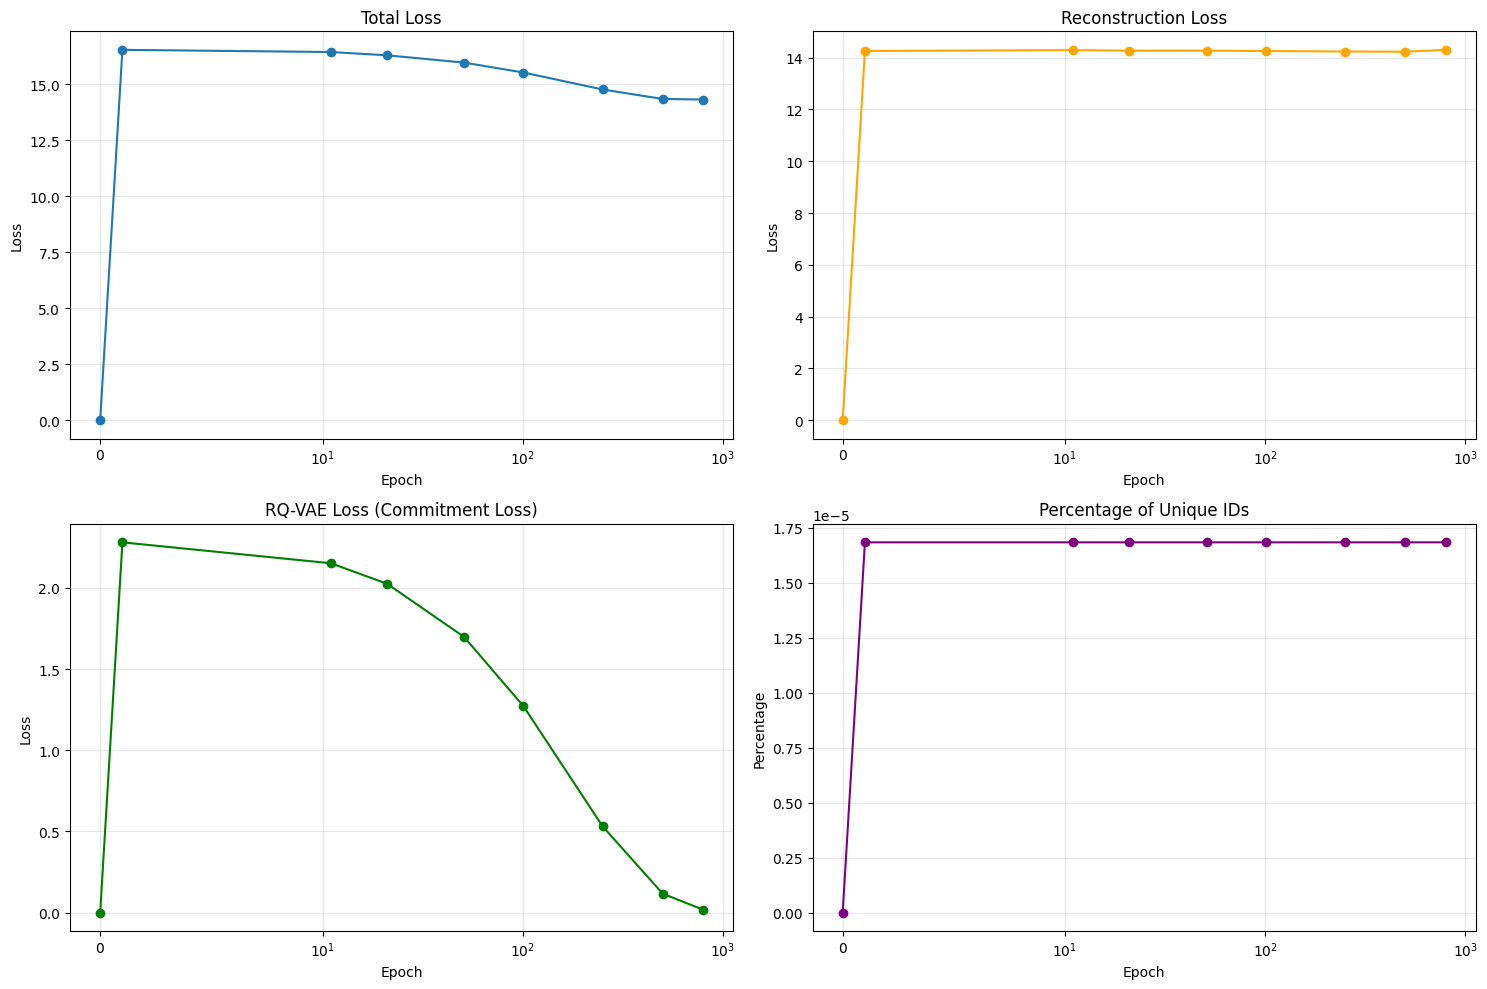


Analyzing codebook norms...


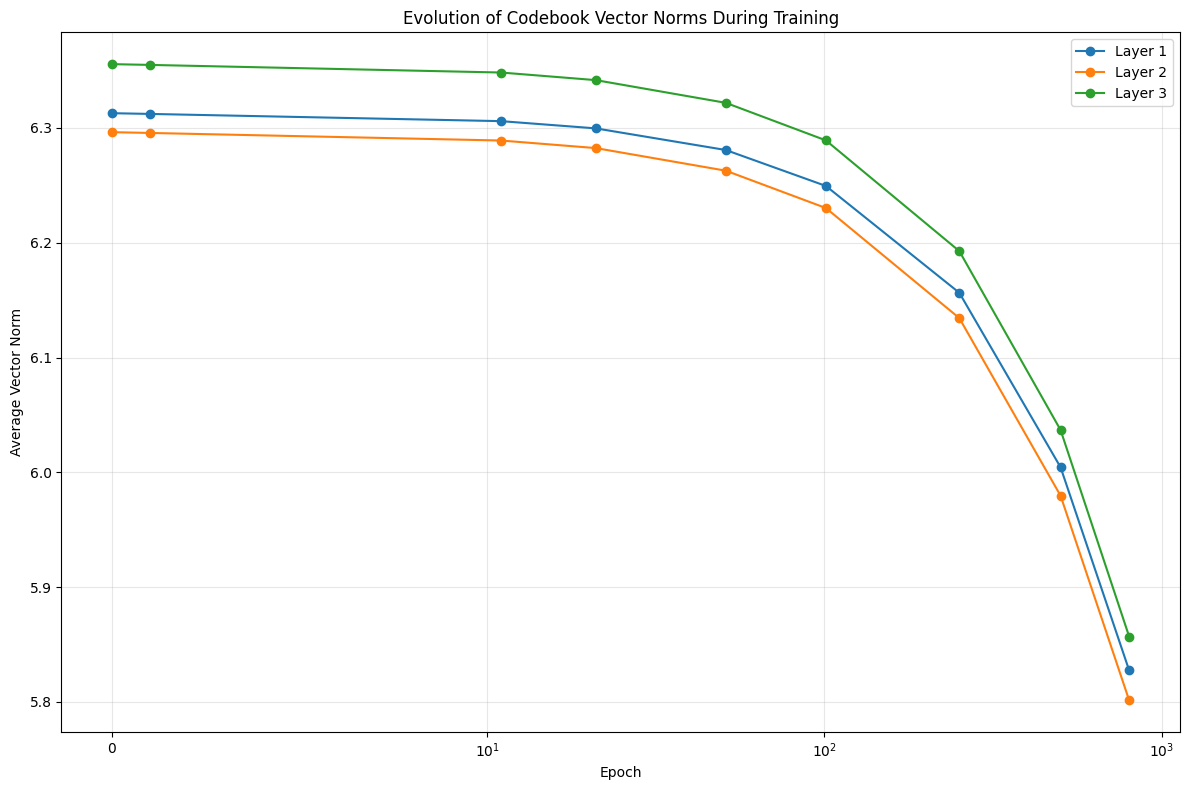


Analyzing codebook distances...


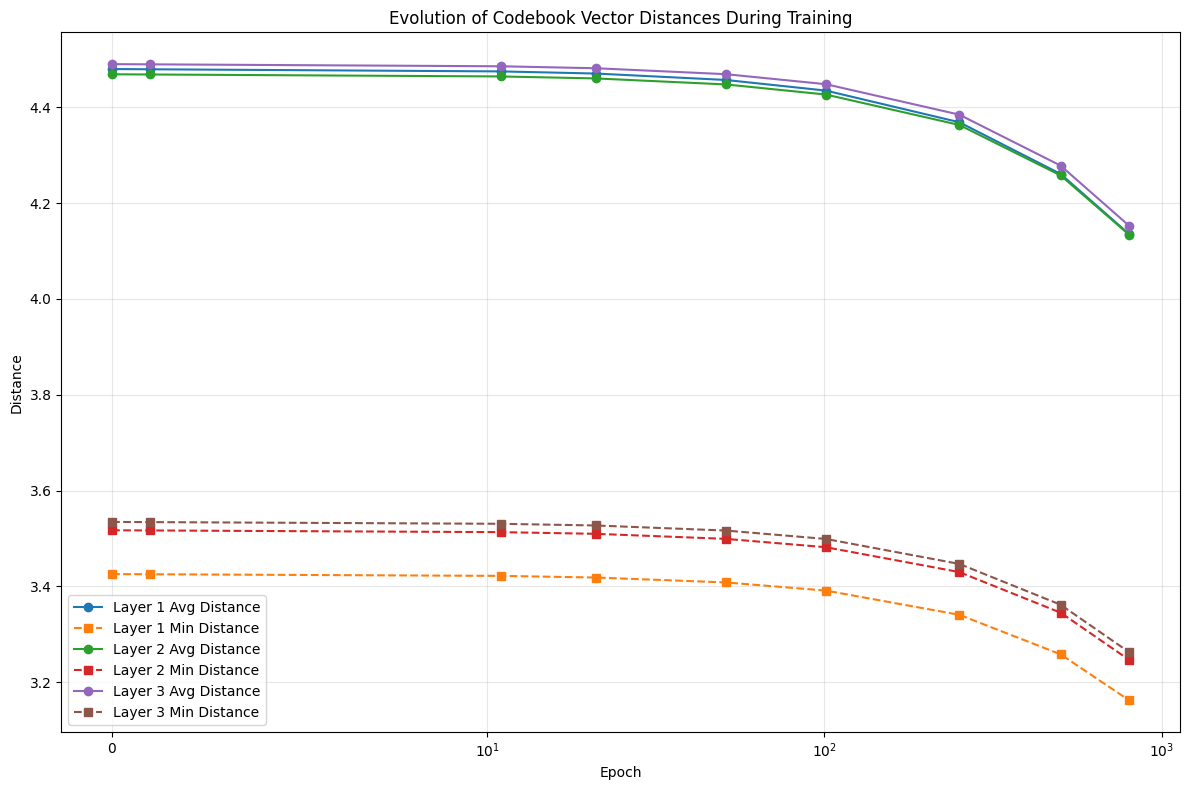


Analyzing codebook usage patterns...


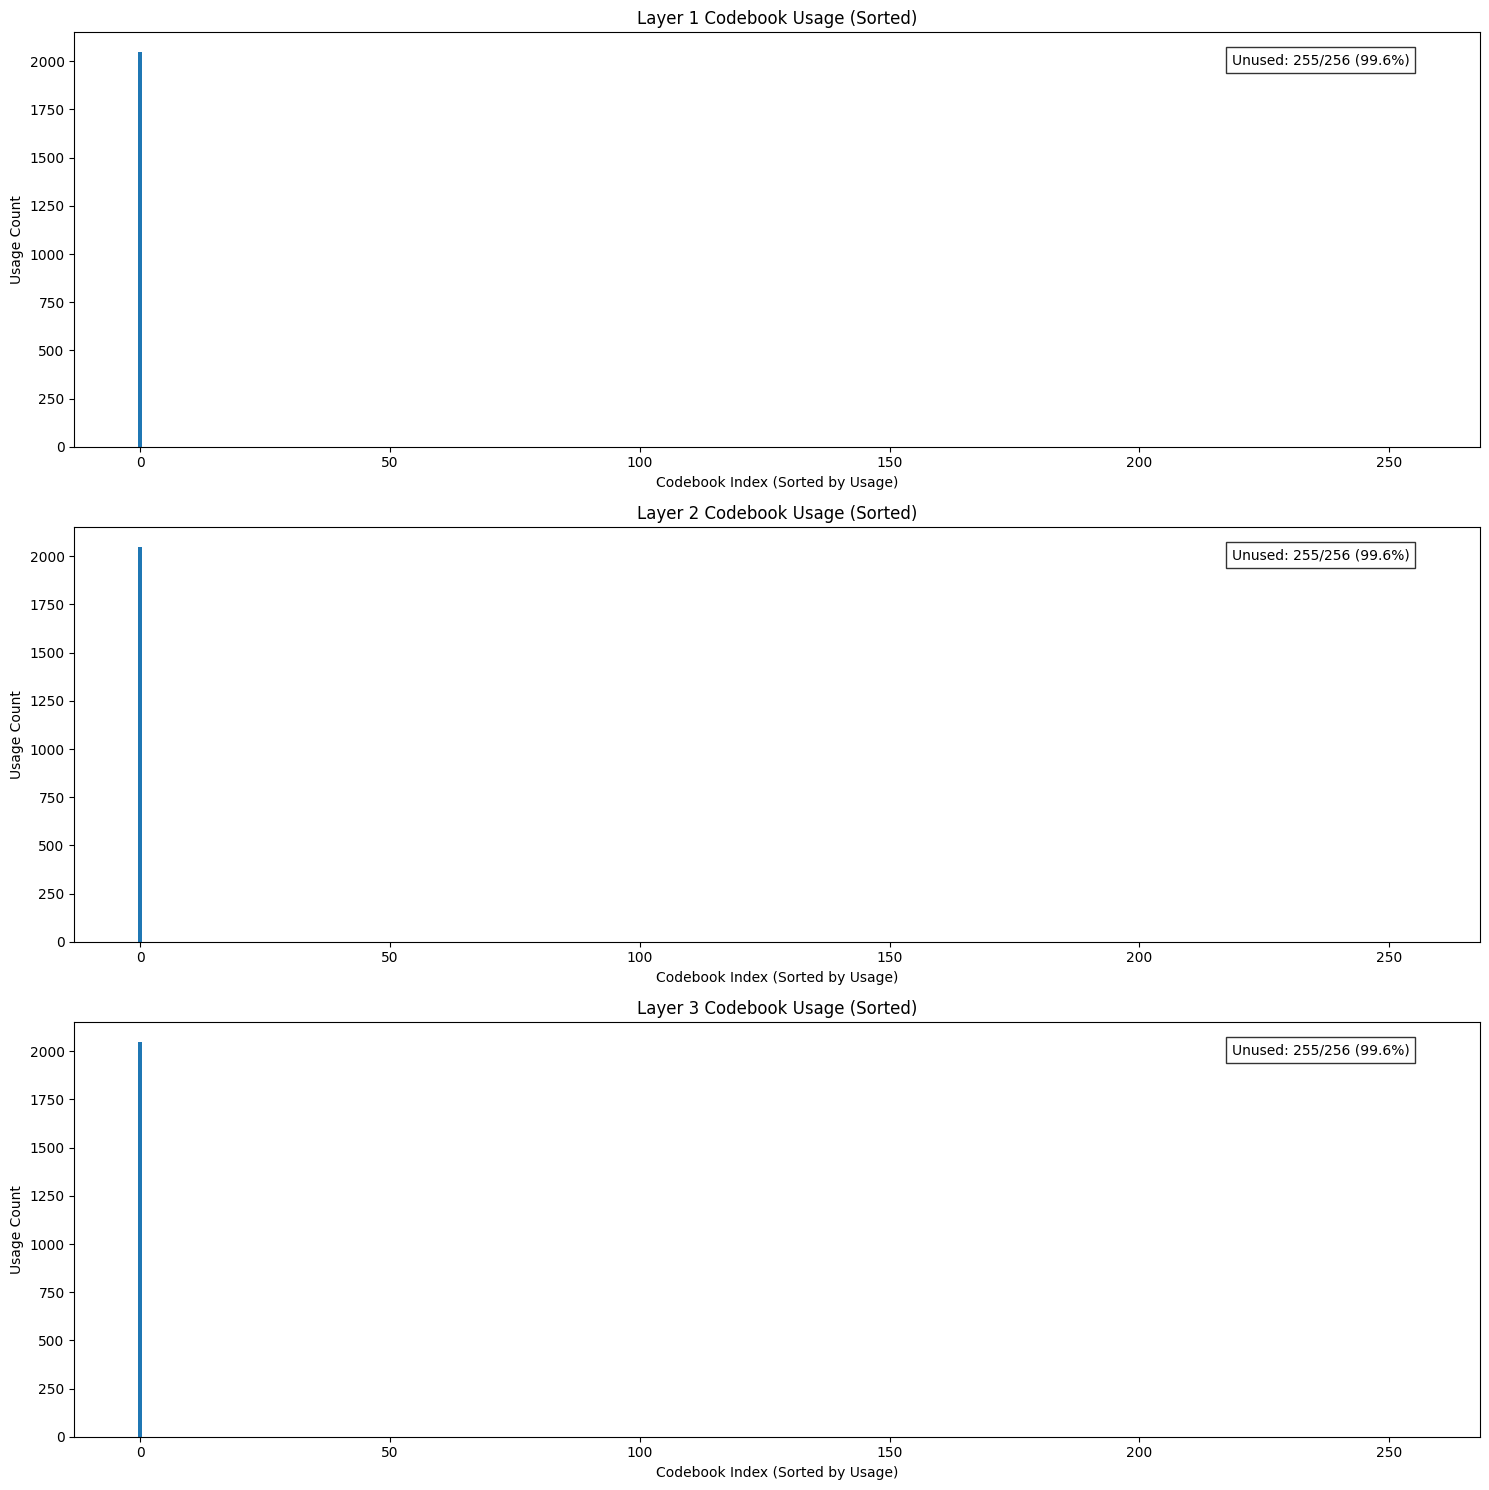

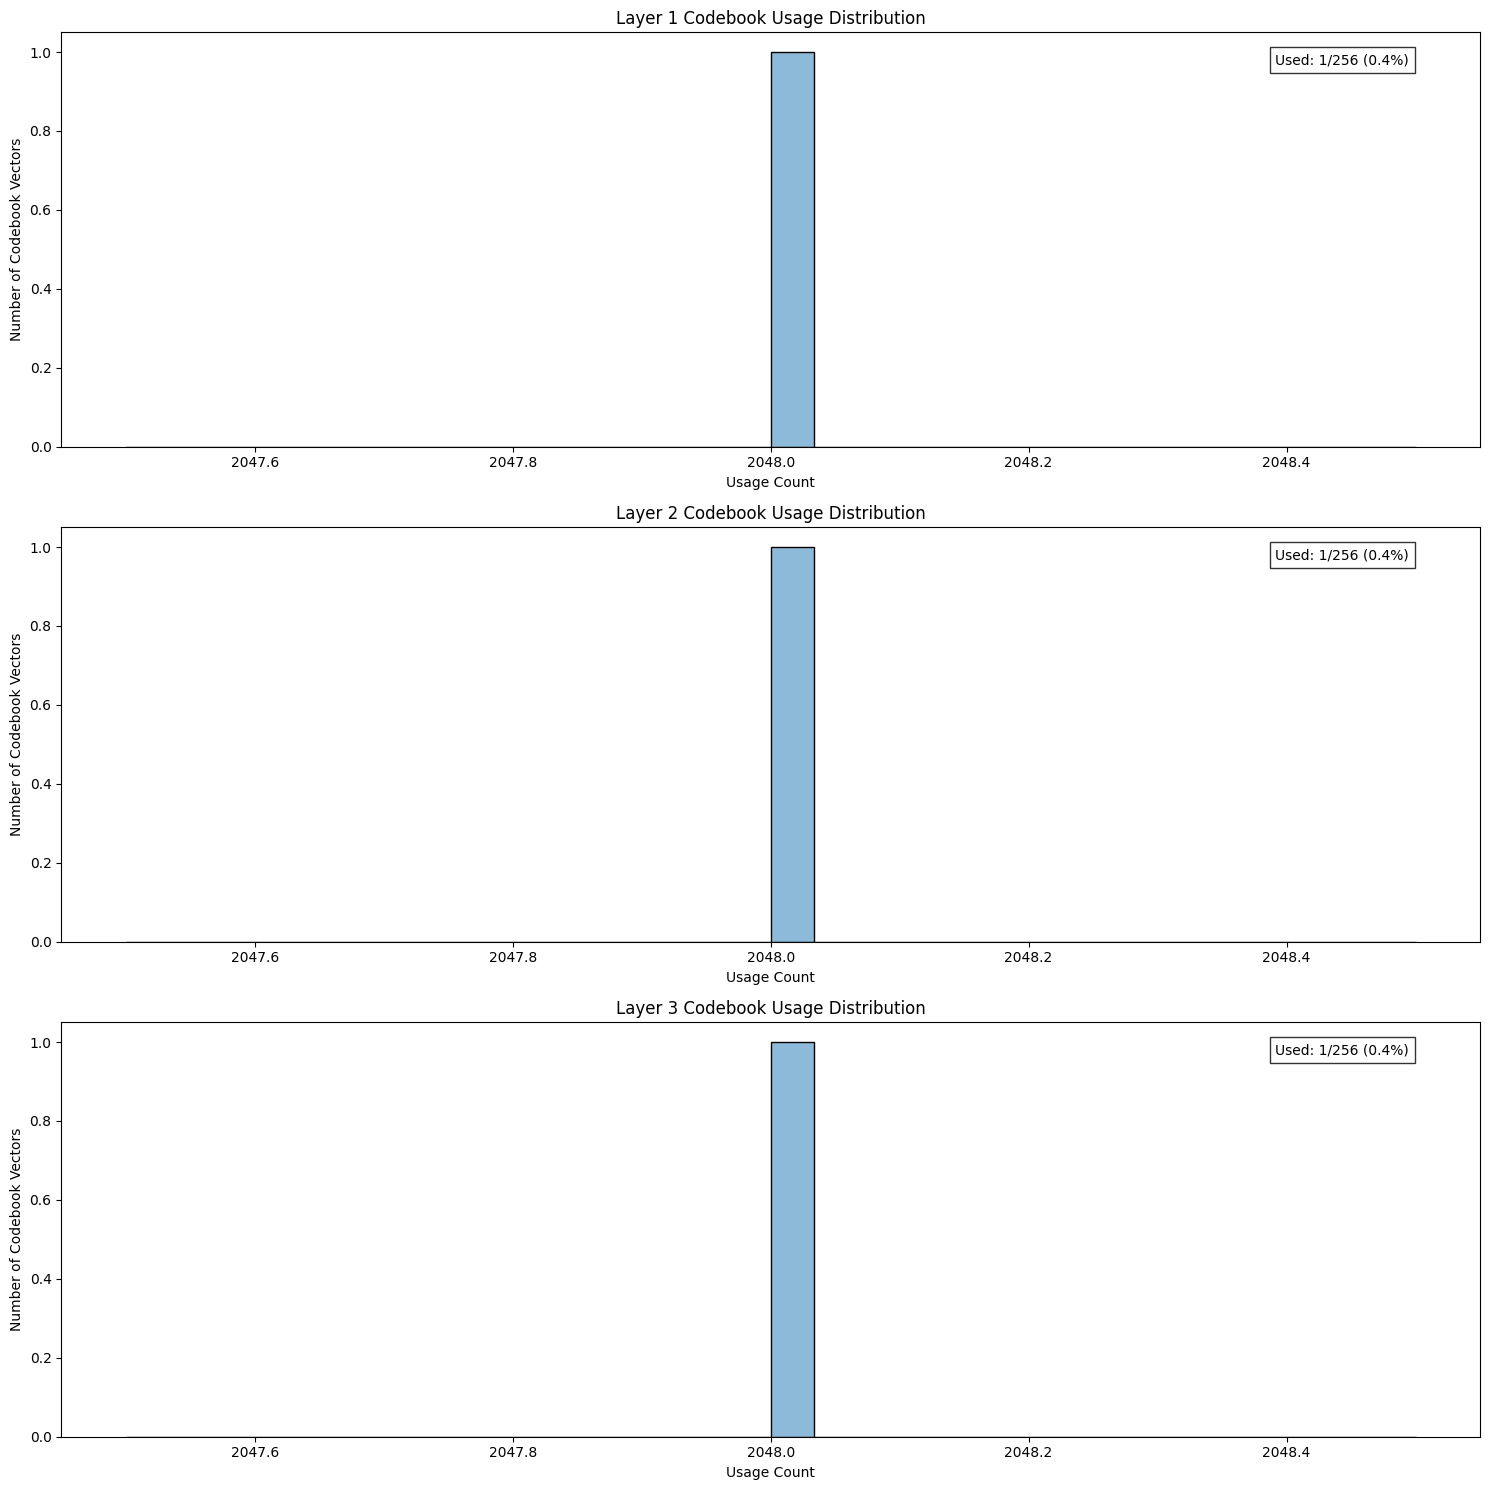


Analysis complete!


In [35]:
do_train = True  # Set to False to skip training and load the model directly
# Usage
if do_train:
    # Train the model with codebook tracking
    codebook_snapshots = train_rqvae_with_analysis(
        model, train_loader, device, 
        num_epochs=iterations, 
        learning_rate=learning_rate, 
        weight_decay=weight_decay
    )
    # You can save the snapshots for later analysis
    torch.save({
        'model_state': model.state_dict(),
        'codebook_snapshots': codebook_snapshots
    }, './models/rq-vae_with_snapshots.pt')
else:
    # Load the model
    model.load_state_dict(torch.load('./models/rq-vae.pt'))
    # You can still analyze usage patterns on the trained model
    visualize_codebook_usage(model, train_loader, device)

In [36]:
sem_ids = []
interactions = pd.read_csv('./data/ml-25m-vit_bert/train.txt')
interactions = interactions.dropna()
num_users = interactions['user'].unique().shape[0]


for i in tqdm(range(59047)):
    song = embeddings[i].clone().detach().unsqueeze(0)
    song = song.to(device)
    with torch.no_grad():
        # embeddings, residuals, sem_ids, quantize_loss
        rqvae_output = model.get_semantic_ids(song, False)
        sem_ids.append(rqvae_output[2])
sem_ids_cpu = [tensor.cpu() for tensor in sem_ids]
sem_ids_cpu = np.array(sem_ids_cpu)[:,0,:]

100%|██████████| 59047/59047 [03:01<00:00, 325.43it/s]


In [37]:
sem_ids_cpu

array([[ 56, 222, 157],
       [ 56, 222, 157],
       [ 56, 222, 157],
       ...,
       [ 56, 222, 157],
       [ 56, 222, 157],
       [ 56, 222, 157]])